In [297]:
import torch
import torch.nn as nn
from copy import deepcopy
from collections import defaultdict, OrderedDict

class XaiHook(object):
    def __init__(self, module, backward=False, hook_fn=None):
        """
        Hook Handler Module
        """
        self.module = module
        self.backward = backward
        if hook_fn is None:
            self.hook_fn = self.default_hook_fn
        else:
            self.hook_fn = hook_fn
        
    def register_hook(self):
        """
        defalut hook_function is save (module, input, output) to (m, i, o)
        if you want to use hook function, change `hook_function` 
        """
        if not self.backward:
            self.hook = self.module.register_forward_hook(self.hook_fn)
        else:
            self.hook = self.module.register_backward_hook(self.hook_fn)
            
    def default_hook_fn(self, m, i, o):
        """
        forward
         - m: module class
         - i: forward input from previous layer
         - o: forward output to next layer
        backward
         - m: module class
         - i: gradient input to next layer (backward out)
         - o: gradient output from previous layer (backward in)
        """
        self.m = m
        self.i = i
        self.o = o
        
    def close(self):
        self.hook.remove()
        self.m = None
        self.i = None
        self.o = None


class XaiBase(nn.Module):
    def __init__(self):
        super(XaiBase, self).__init__()
        """
        need to define hook function at each method
        - f_hook
        - b_hook
        """
        self._reset_maps()
    
    def _reset_maps(self):
        self.maps = OrderedDict()
        
    def _save_maps(self, layer_name, x):
        self.maps[layer_name] = x    
        
    def _register(self, hooks):
        """
        - need to define XaiHook class to use
        - defalut hook_function is save (module, input, output) to (m, i, o)
          if you want to use hook function, change `hook_function` 
        """
        if not isinstance(hooks, list):
            hooks = [hooks]
        for hook in hooks:
            hook.register_hook()
            
    def _reset_hooks(self, hooks):
        if not isinstance(hooks, list):
            hooks = [hooks]
        for hook in hooks:
            hook.close()

    def _return_indices(self, layers, on=True):
        """
        support for cnn layer which have `nn.MaxPool2d`,
        you can turn on/off pooling indices.
        please define a forward function to use it in your model
        '''
        # in your model
        def forward_switch(self, x):
            switches = OrderedDict()
            self.return_indices(on=True)
            for idx, layer in enumerate(self.convs):
                if isinstance(layer, nn.MaxPool2d):
                    x, indices = layer(x)
                    switches[idx] = indices
                else:
                    x = layer(x)
            self.return_indices(on=False)
            return x, switches
        '''
        """
        if on:
            for layer in layers:
                if isinstance(layer, nn.MaxPool2d):
                    layer.return_indices = True
        else:
            for layer in layers:
                if isinstance(layer, nn.MaxPool2d):
                    layer.return_indices = False  
                    
                    
class XaiModel(XaiBase):
    def __init__(self, model):
        super(XaiModel, self).__init__()
        self.model = deepcopy(model)
        self.model.eval()
        
    def one_hot(self, targets, module_name):
        """
        one hot vectorize the target tensor
        args:
        - targets: torch.LongTensor, target classes that have size of mini-batch
        - module_name: str, feature name for Fully-Connected Network or any Task-specific Network
        return:
        - one hot vector of targets
        """
        assert isinstance(targets, torch.LongTensor), "`targets` must be `torch.LongTensor` type"
        assert isinstance(module_name, str), "`module_name` must be `str` type"
        modules = self.model._modules[module_name]
        if isinstance(modules, nn.Sequential):
            last_layer = modules[-1]
        else:
            last_layer = modules
        assert isinstance(last_layer, nn.Linear), "`last layer` must be `torch.nn.Linear`"
        target_size = self.model._modules[module_name][-1].out_features
        B = targets.size(0)
        one_hot = torch.zeros((B, target_size))
        one_hot.scatter_(1, targets.unsqueeze(1), 1.0)
        return one_hot.to(targets.device)
    
    def find_target_layer_idx(self, module_name, layer_names):
        assert isinstance(layer_names, list), "use list for `layer_names`"
        layer_names = [l.lower() for l in layer_names]
        idxes = defaultdict(list)
        modules = self.model._modules[module_name]
        assert isinstance(modules, nn.Sequential), "use this function for `nn.Sequential` type modules"
        for idx, layer in modules.named_children():
            l_name = type(layer).__name__.lower()
            if l_name in layer_names:
                idxes[l_name].append(int(idx))

        return idxes

In [311]:
class ChannelAttention(nn.Module):
    """Channel Attention Module"""
    def __init__(self, C, ratio):
        """
        Method in [arXiv:1807.06521]
        args:
         - C: channel of input features
         - H: height of input features
         - W: width of input features
         - hid_size: hidden size of shallow network
         - ratio: reduction ratio
        """
        super(ChannelAttention, self).__init__()
        assert isinstance(2*C // ratio, int), "`2*C // ratio` must be int "
        self.maxpool = nn.AdaptiveMaxPool2d((1, 1))
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.shallow_net = nn.Sequential(
            nn.Linear(2*C, 2*C // ratio),
            nn.ReLU(),
            nn.Linear(2*C // ratio, 2*C),
        )
    
    def forward(self, x):
        # (B, C, H, W) > (B, 2*C, 1, 1)
        x = torch.cat([self.maxpool(x), self.avgpool(x)], dim=1)
        # (B, 2*C) > (B, 2*C//2) > (B, 2*C)
        x = self.shallow_net(x.squeeze(-1).squeeze(-1))
        # (B, C), (B, C)
        x_max, x_avg = torch.chunk(x, 2, dim=1)
        # not using softmax in paper: something like gate function
        x = torch.sigmoid(x_max + x_avg)
        return x.unsqueeze(-1).unsqueeze(-1)

In [312]:
class SpatialAttention(nn.Module):
    """Spatial Attention Module"""
    def __init__(self, H, W, K_H=7, K_W=7, S_H=1, S_W=1):
        """
        Method in [arXiv:1807.06521]
        args:
         - H: height of input features
         - W: width of input features
         - K_H: height of kernel size
         - K_W: width of kernel size
         - S_H: stride height of conv layer
         - S_W: stride width of conv layer
        """
        super(SpatialAttention, self).__init__()
        P_H = self.cal_padding_size(H, K_H, S_H)
        P_W = self.cal_padding_size(W, K_W, S_W)
        kernel_size = (K_H, K_W)
        stride = (S_H, S_W)
        padding = (P_H, P_W)
        # same padding conv layer
        self.conv_layer = nn.Conv2d(2, 1, kernel_size, stride, padding)
    
    def cal_padding_size(self, x, K, S):
        return int((S * (x-1) + K - x) / 2)
    
    def forward(self, x):
        # (B, C, H, W) > (B, 1, H, W)
        x_max, _ = torch.max(x, dim=1, keepdim=True)
        x_avg = torch.mean(x, dim=1, keepdim=True)
        # (B, 2, H, W)
        x = torch.cat([x_max, x_avg], dim=1)
        # (B, 2, H, W) > (B, 1, H, W)
        x = self.conv_layer(x)
        # return gated features
        return torch.sigmoid(x)

In [313]:
class CBAM(nn.Module):
    """Convolution Block Attention Module"""
    def __init__(self, C, H, W, ratio, K_H=7, K_W=7, S_H=1, S_W=1):
        """
        Method in [arXiv:1807.06521]
        args:
         - C: channel of input features
         - H: height of input features
         - W: width of input features
         - ratio: reduction ratio
         - K_H: height of kernel size
         - K_W: width of kernel size
         - S_H: stride height of conv layer
         - S_W: stride width of conv layer
         
        return:
         - attentioned features, size = (B, C, H, W)
        """
        super(CBAM, self).__init__()
        self.channel_attn = ChannelAttention(C, ratio)
        self.spatial_attn = SpatialAttention(H, W, K_H, K_W, S_H, S_W)
        
    def forward(self, x, return_attn=False):
        """
        return: attentioned features, size = (B, C, H, W)
        """
        out = x
        c_attn = self.channel_attn(out)
        out = c_attn * out
        s_attn = self.spatial_attn(out)
        out = s_attn * out
        if return_attn:
            return out, (c_attn, s_attn)
        return out

In [314]:
import torch
import torch.nn as nn
from collections import OrderedDict

class CnnWithCBAM(XaiBase):
    def __init__(self):
        super(CnnWithCBAM, self).__init__()

        self.convs = nn.Sequential(
            nn.Conv2d(1, 32, 5),  # (B, 1, 28, 28) > (B, 32, 24, 24)
            CBAM(32, 24, 24, 16),
            nn.ReLU(),
            nn.MaxPool2d(2),  # (B, 32, 24, 24) > (B, 32, 12, 12)
            nn.Conv2d(32, 64, 3),  # (B, 32, 12, 12) > (B, 64, 10, 10)
            CBAM(64, 10, 10, 16),
            nn.ReLU(), 
            nn.MaxPool2d(2),  # (B, 64, 10, 10) > (B, 64, 5, 5)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(64*5*5, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        
    def forward(self, x):        
        x = self.convs(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def forward_map(self, x):
        self._reset_maps()
        for i, layer in enumerate(self.convs):
            layer_name = type(layer).__name__
            if layer_name == "CBAM":
                x, attns = layer(x, return_attn=True)
                self._save_maps(f"{i}"+layer_name, attns)
            else:
                x = layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [315]:
model = CnnWithCBAM()

In [423]:
import torch.nn.functional as F

class GradCAM(XaiModel):
    def __init__(self, model, norm_mode=1):
        """
        norm mode
        - 1 ( 0, 1) min-max normalization
        - 2 (-1, 1) min-max normalization
        - 3 mean-std normalization
        """
        super(GradCAM, self).__init__(model)
        self.norm_mode = norm_mode
        self.global_avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        relu_idxes = self.find_target_layer_idx(module_name="convs", layer_names=["relu"])
        self.last_relu_idx = relu_idxes["relu"][-1]
        # get Rectified Conv Features Maps
        self.f_hook = XaiHook(self.model.convs[self.last_relu_idx])
        self.b_hook = XaiHook(self.model.convs[self.last_relu_idx], backward=True)
        self.hooks = [self.f_hook, self.b_hook]
    
    def cal_gradcam(self):
        # (B, C, H, W) > (B, C, 1, 1)
        alpha = self.global_avgpool(self.b_hook.i[0])
        # sum( (B, C, 1, 1) * (B, C, H, W) , dim=1) > (B, 1, H, W)
        gradcam = torch.relu((alpha * self.f_hook.o).sum(1, keepdim=True))
        return gradcam
        
    def post_processing(self, gradcam, H, W):
        """
        interpolate(up sample) & normalize
        https://pytorch.org/docs/stable/nn.functional.html#interpolate
        """
        gradcam = F.interpolate(gradcam, size=(H, W), mode="bilinear", align_corners=False)
        gradcam = self.normalization(gradcam)
        return gradcam
    
    def normalization(self, tensor):
        B, C, H, W = tensor.size()
        tensor = tensor.view(B, -1)
        t_min = tensor.min(dim=1, keepdim=True)[0]
        t_max = tensor.max(dim=1, keepdim=True)[0]
        t_mean = tensor.mean(dim=1, keepdim=True)
        t_std = tensor.std(dim=1, keepdim=True)
        if self.norm_mode == 1:
            tensor -= t_min
            tensor /= (t_max - t_min)
        elif self.norm_mode == 2:
            tensor -= t_min
            tensor *= 2
            tensor /= (t_max - t_min)
        elif self.norm_mode == 3:
            tensor -= t_mean
            tensor /= t_std
        return tensor.view(B, C, H, W)
        
    def get_attribution(self, x, targets):
        *_, H, W = x.size()
        self._register(self.hooks)
        self.model.zero_grad()
        
        output = self.model(x)
        grad = self.one_hot(targets, module_name="fc")
        output.backward(grad)
        
        gradcam = self.cal_gradcam()
        gradcam = self.post_processing(gradcam, H, W)
        
        self._reset_hooks(self.hooks)
        return gradcam.detach()

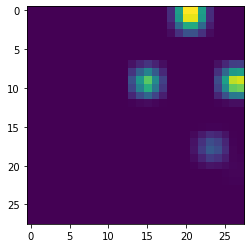

In [438]:
import matplotlib.pyplot as plt

gradcam_model = GradCAM(model)
x = torch.rand(1, 1, 28, 28)
targets = torch.LongTensor([2])
gradcam = gradcam_model.get_attribution(x, targets)
plt.imshow(gradcam.squeeze())
plt.show()

In [303]:
class GuidedBackprop(XaiModel):
    def __init__(self, model):
        super(GuidedBackprop, self).__init__(model)
        self.register_guided_hooks(self.model.convs)
        
    def register_guided_hooks(self, layers):
        self.relu_hooks = []
        self.reset_f_switches()
        for layer in layers:
            layer_name = type(layer).__name__
            if layer_name.lower() == "relu":
                def guided_forward(m, i, o):
                    self.f_switches.append(o.data)
                f_hook = XaiHook(layer, hook_fn=guided_forward)

                def guided_backward(m, i, o):
                    deconv_grad = o[0].clamp(min=0)  # o: backward input
                    forward_output = self.f_switches.pop(-1)
                    forward_mask = forward_output.ne(0.0).type_as(forward_output)
                    grad_in = deconv_grad * forward_mask
                    return (grad_in, )
                
                b_hook = XaiHook(layer, backward=True, hook_fn=guided_backward)
                
                self.relu_hooks.append(f_hook)
                self.relu_hooks.append(b_hook)
                
        # register forward hooks
        self._register(self.relu_hooks)
        
    def get_attribution(self, x, targets):
        x.requires_grad_(True)
        
                
        x_grad = x.grad.data
        x.requires_grad_(False)

In [30]:
torch.manual_seed(5)
x = torch.randn(1, 1, 5, 5)
conv_layer = nn.Conv2d(1, 1, 2, 1)
relu = nn.ReLU()
def f_hook(m, i, o):
    print(m)
    print(type(m))
    print("forward_input")
    for a in i:
        print(a)
    print("forward_output")
    print(o)
    print()

def b_hook(m, i, o):
    print(m)
    print(type(m))
    print("grad_input")
    for a in i:
        print(a)
    print("grad_output")
    for a in o:
        print(a)
    print()

conv_layer.register_forward_hook(f_hook)
relu.register_forward_hook(f_hook)
conv_layer.register_backward_hook(b_hook)
relu.register_backward_hook(b_hook)
o1 = conv_layer(x)
o2 = relu(o1)
o2_mask = (o2 == 0.0).byte()
grad = torch.randn(1, 1, 3, 3)
grad_mask = (grad < 0).byte()

Conv2d(1, 1, kernel_size=(2, 2), stride=(1, 1))
<class 'torch.nn.modules.conv.Conv2d'>
forward_input
tensor([[[[ 1.8423,  0.5189, -1.7119, -1.7014,  2.0194],
          [-0.2686, -0.1307, -1.4374,  0.3908, -0.4340],
          [ 0.3523, -0.0646,  0.7686,  0.9233, -0.5583],
          [ 0.7796, -0.2617,  0.0317, -1.1724, -1.5069],
          [-0.1481,  0.3715,  0.2273, -0.0647, -0.1479]]]])
forward_output
tensor([[[[-0.2046,  0.5226,  1.2223, -0.3424],
          [ 0.5551,  1.3434,  0.9570,  0.5442],
          [ 0.4624,  0.0151, -0.5609, -0.3226],
          [ 0.5154,  0.5963,  0.9527,  1.1736]]]],
       grad_fn=<ThnnConv2DBackward>)

ReLU()
<class 'torch.nn.modules.activation.ReLU'>
forward_input
tensor([[[[-0.2046,  0.5226,  1.2223, -0.3424],
          [ 0.5551,  1.3434,  0.9570,  0.5442],
          [ 0.4624,  0.0151, -0.5609, -0.3226],
          [ 0.5154,  0.5963,  0.9527,  1.1736]]]],
       grad_fn=<ThnnConv2DBackward>)
forward_output
tensor([[[[0.0000, 0.5226, 1.2223, 0.0000],
        

In [31]:
o2_mask

tensor([[[[1, 0, 0, 1],
          [0, 0, 0, 0],
          [0, 0, 1, 1],
          [0, 0, 0, 0]]]], dtype=torch.uint8)

In [32]:
grad_mask

tensor([[[[1, 0, 0],
          [0, 0, 0],
          [0, 1, 0]]]], dtype=torch.uint8)

In [33]:
grad

tensor([[[[-1.1333,  1.5883,  0.0059],
          [ 0.6205,  0.8599,  0.9125],
          [ 1.2162, -1.2440,  0.7325]]]])

In [34]:
(1 - o2.mean()).backward()

ReLU()
<class 'torch.nn.modules.activation.ReLU'>
grad_input
tensor([[[[ 0.0000, -0.0625, -0.0625,  0.0000],
          [-0.0625, -0.0625, -0.0625, -0.0625],
          [-0.0625, -0.0625,  0.0000,  0.0000],
          [-0.0625, -0.0625, -0.0625, -0.0625]]]])
grad_output
tensor([[[[-0.0625, -0.0625, -0.0625, -0.0625],
          [-0.0625, -0.0625, -0.0625, -0.0625],
          [-0.0625, -0.0625, -0.0625, -0.0625],
          [-0.0625, -0.0625, -0.0625, -0.0625]]]])

Conv2d(1, 1, kernel_size=(2, 2), stride=(1, 1))
<class 'torch.nn.modules.conv.Conv2d'>
grad_input
None
tensor([[[[ 0.1859,  0.4519],
          [-0.0822, -0.0112]]]])
tensor([-0.7500])
grad_output
tensor([[[[ 0.0000, -0.0625, -0.0625,  0.0000],
          [-0.0625, -0.0625, -0.0625, -0.0625],
          [-0.0625, -0.0625,  0.0000,  0.0000],
          [-0.0625, -0.0625, -0.0625, -0.0625]]]])

